

### <b><span style='color:#F1A424'>Test Classification</span></b>

- Text classification is one of the most common tasks in NLP
- It can be used for a wide range of applications (eg. tagging customer feedback into categories, routing support tickets according to their language)
- Another common type of text classification problem is **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">sentiment analysis</mark>** which aims to **identify the polatity** of a given text (+/-)

### <b><span style='color:#F1A424'>Our Task</span></b>

- We need to build a system that will be able to automatically identify emotional states (eg. anger, joy) that people express about your company's product on twitter
- For this task, we'll be using a variant of **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">BERT</mark>**; **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">DistilBERT</mark>**, the main advantage of this model is that it is much smaller than **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">BERT</mark>** (ie. more efficient), but is able to achieve comparable performance
- We will be using three core libraries from the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Hugging Face</mark>** ecosystem: **<span style='color:#FFC300'>Datasets</span>**, **<span style='color:#FFC300'>Tokenizers</span>** & **<span style='color:#FFC300'>Transformers</span>**

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#3b3745"><b><span style='color:#F1A424'>1 |</span></b> <b>THE DATASET</b></div>
    
- Many data sets involving **sentiment** analysis are **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">binary</mark>** classification problems 
- In this dataset we have **6 different sentiments**, which means we'll be treating this problem as a **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">multiclass</mark>** classification problem

In [1]:
!ls /kaggle/input/emotion-dataset/

test.csv  training.csv	validation.csv


In [2]:
pip install panel

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import panel as pn
import warnings; warnings.filterwarnings('ignore')

def show_panel(df):
    return pn.widgets.Tabulator(df.head(20),
                    show_index=False,
                    pagination='local', 
                         page_size=10)
    
    
pn.extension('tabulator')
pn.widgets.Tabulator.theme = 'bootstrap'

validation = pd.read_csv('/kaggle/input/emotion-dataset/validation.csv')
train = pd.read_csv('/kaggle/input/emotion-dataset/training.csv')
test = pd.read_csv('/kaggle/input/emotion-dataset/test.csv')

print('Dataset information:')
print(f'Training data: {train.shape}')
print(f'Validation data: {validation.shape}')
print(f'Test data: {test.shape}')

Dataset information:
Training data: (16000, 2)
Validation data: (2000, 2)
Test data: (2000, 2)


In [4]:
show_panel(train)

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

### <b><span style='color:#F1A424'>Combine DataFrames into Dataset</span></b>
- It can be more intuitive to utilise **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">HuggingFace</mark>**'s Dataset  

In [5]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [6]:
from datasets import Dataset,DatasetDict,Features,Value,ClassLabel

# Don't forget the class label data
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
ft = Features({'text': Value('string'), 'label': ClassLabel(names=class_names)})

# Combine Multiple Datasets 
emotions = DatasetDict({
    "train": Dataset.from_pandas(train,features=ft),
    "test": Dataset.from_pandas(test,features=ft),
    "validation": Dataset.from_pandas(validation,features=ft)
    })

# Convert a single DataFrame to a Dataset
# emotions = Dataset.from_pandas(train,features=ft)

emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

### <b><span style='color:#F1A424'>Selecting a Subset</span></b>
- We'll be working with the **training and validation dataset** in this problem
- Lets just show some useful fearures of the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Dataset</mark>** class

In [7]:
# Training Data
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [8]:
# Get First 5 Entries in Dictionary Format (Group them)
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

### <b><span style='color:#F1A424'>Dataset to DataFrame Convertion</span></b>
- Whenever we need a pandas `DataFrame`, eg. for visualisations, we can utlise the `Dataset`'' method `.set_format`

In [9]:
# Convert Dataset to DataFrame (don't forget to reset)
emotions.set_format(type="pandas")
df = emotions["train"][:]
show_panel(df)

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

### <b><span style='color:#F1A424'>Adding Label Data</span></b>
- We made sure to not forget the `label_names` when converting from `DataFrame` to `Dataset`
- We can convert **numeric** values to **string** values by using method `int2str`

In [10]:
# Add label data to dataframe
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
show_panel(df)

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#3b3745"><b><span style='color:#F1A424'>2 |</span></b> <b>CLASS DISTRIBUTION</b></div>

- Our dataset has 6 classes `joy`, `sadness`, `anger`, `fear`, `love` and `surprise`; multiclass problem

In [11]:
import plotly.express as px

px.bar(df['label_name'].value_counts(ascending=True),template='plotly_white')

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#3b3745"><b><span style='color:#F1A424'>3 |</span></b> <b>LENGTH OF EACH TWEET</b></div>

- For applications using **DistilBERT**, the maximum context size is **512 tokens**
- Most tweets are around **10-20 words** long, which falls well within this limit

In [12]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)

px.box(df,y='Words Per Tweet',
       color='label_name',
       template='plotly_white')

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#3b3745"><b><span style='color:#F1A424'>4 |</span></b> <b>TOKENISATION</b></div>

- As with other models, **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">DistilBERT</mark>** cannot receive raw python strings as input
- Instead we need to break down the strings into subgroups called **tokens** and encode them as **numerical vectors**
- Let's consider two types of **tokenisation** approaches: **<span style='color:#FFC300'>character</span>** & **<span style='color:#FFC300'>word</span>** tokenisation

### <b><span style='color:#F1A424'> 4.1 | </span>Character tokenisation </b> 

The simplest tokenisation approach is **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">character tokenisation</mark>**, we can use python's inbuilt **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">list</mark>** class

In [13]:
text = 'Tokenisation of text is a core task of NLP.'
tokenised_text = list(text)

# Character Tokenised list
print(f'Number of tokens: {len(tokenised_text)}')
print(tokenised_text)

Number of tokens: 43
['T', 'o', 'k', 'e', 'n', 'i', 's', 'a', 't', 'i', 'o', 'n', ' ', 'o', 'f', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


- Convert each character into an integer (numericalisation)
- `token2idx` gives us a mapping from each character in the **vocabulary** to a unique integer

In [14]:
# Mapping Vecabulary dictionary
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenised_text)))}

print(f'Length of vocabulary: {len(token2idx)}')
print(token2idx)

Length of vocabulary: 18
{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'i': 10, 'k': 11, 'n': 12, 'o': 13, 'r': 14, 's': 15, 't': 16, 'x': 17}


### <b><span style='color:#F1A424'>Reconstructing text</span></b>
- Once we have a vocabulary dictionary, we can reconstruct the 

In [15]:
# Let's represent text in numerical format 
input_ids = [token2idx[token] for token in tokenised_text]

print(f'{len(input_ids)} characters')
print(input_ids)

43 characters
[5, 13, 11, 8, 12, 10, 15, 6, 16, 10, 13, 12, 0, 13, 9, 0, 16, 8, 17, 16, 0, 10, 15, 0, 6, 0, 7, 13, 14, 8, 0, 16, 6, 15, 11, 0, 13, 9, 0, 3, 2, 4, 1]


### <b><span style='color:#F1A424'>Convert to OHE</span></b>

- Last step is to convert `input_ids` to a 2D tensor of one-hot vectors, let's use pytorch below
- One-Hot vectors are frequently used in ML applications to encode **categorical data** (either ordinal or nominal)
- For each of the 42 input token, we now have a one-hot vector with 18 dimensions (vocab size)

In [16]:
import torch
import torch.nn.functional as F

inputs_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(inputs_ids,num_classes = len(token2idx))
print(f'OHE size: {one_hot_encodings.shape}')

OHE size: torch.Size([43, 18])


### <b><span style='color:#F1A424'>Drawbacks of Character Tokenisation</span></b>

- Character level tokenisation ignores any structure in the text & treats the whole string as a stream of characters
- This helps deal with missspellings and rear words, but the main drawback is that linguistic structures need to be learned from the data 
- **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Character tokenisation</mark>** is rarely used in practice, instead **some structure of the text is preserved** if we utilise **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Word Tokenisation</mark>**

### <b><span style='color:#F1A424'> 4.2 | </span>Word tokenisation </b> 

- Instead of splitting the text into characters, we can split **it into words** & **map each word to an integer**
- The simplest form of tokenisation is if we utilise python's inbuilt **string** class `split` method 
- Unlike **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Character tokenisation</mark>**, if we have declinations, conjugations, misspellings, the size of the **vocabulary dictionary** can grow very rapidly
- Larger **vocabularies** are a problem, because it requires the model to have an excess of parameters (which is inefficient)


- It's common to select the **<span style='color:#FFC300'>most common 100,000 words</span>** in the **corpus**
- words that are not part of the vocabulary are classified as unknown and mapped to a shared **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">UNK</mark>** token
- However, can potentially lose some important information during the process of tokenisation, since the model has no information about words associated with **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">UNK</mark>**

In [17]:
tokenised_text = text.split()
print(tokenised_text)

['Tokenisation', 'of', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


### <b><span style='color:#F1A424'> 4.3 | </span>Subword tokenisation </b> 

- **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Subword tokenization</mark>** is to combine the best aspects of **<span style='color:#FFC300'>character</span>** & **<span style='color:#FFC300'>word</span>** tokenisation
- The main distinguishing feature of **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Subword tokenization</mark>** is that it is learned from a **pretraining corpus** using a mix of statistical rules and algorithms


- There are several **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Subword tokenization</mark>** algorithms that are commonly used in NLP
    - let’s start with `WordPiece`, which is used by the `BERT` and `DistilBERT` tokenizers
    

- `AutoTokenizer` class allows us to quickly load te tokeniser associated with a pretrained model
- Or we can load the Tokeniser manually from `transformers.DistilBertTokenizer`



In [18]:
# from transformers import AutoTokenizer, AutoConfig

# text = 'Tokenisation of text is a core task of NLP.'

# # Load parameters of the tokeniser
# model_ckpt = "distilbert-base-uncased"

# # Check the maximum sequence length supported by the model
# config = AutoConfig.from_pretrained(model_ckpt)
# max_sequence_length = config.max_position_embeddings
# print(f"Maximum sequence length supported by the model: {max_sequence_length}")

# # Set the maximum length for tokenization
# max_length = min(4096, max_sequence_length)  # Set a maximum length (4096 or the model's maximum, whichever is smaller)

# # Load the tokenizer with the desired maximum length
# tokenizer = AutoTokenizer.from_pretrained(model_ckpt, model_max_length=max_length)

In [19]:
from transformers import AutoTokenizer

text = 'Tokenisation of text is a core task of NLP.'

# Load parameters of the tokeniser
model_ckpt = "distilbert-base-uncased"
max_length = 4096  # Set a large value for maximum length
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, model_max_length=max_length)

# Show tokeniser information
tokenizer

# Or we can load the Tokeniser manually `transformers.DistilBertTokenizer`

# from transformers import DistilBertTokenizer

# model_ckpt = "distilbert-base-uncased"
# distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
# distilbert_tokenizer

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [20]:
print('')
print(f'Vocab size: {tokenizer.vocab_size}')
print(f'Max length: {tokenizer.model_max_length}')
print(f'Tokeniser model input names: {tokenizer.model_input_names}')


Vocab size: 30522
Max length: 512
Tokeniser model input names: ['input_ids', 'attention_mask']


In [21]:
print('Encoded text')
encoded_text = tokenizer(text)
print(encoded_text,'\n')

print('Tokens')
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens,'\n')

print('Convert tokens to string')
print(tokenizer.convert_tokens_to_string(tokens),'\n')

Encoded text
{'input_ids': [101, 19204, 6648, 1997, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]} 

Tokens
['[CLS]', 'token', '##isation', 'of', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]'] 

Convert tokens to string
[CLS] tokenisation of text is a core task of nlp. [SEP] 



In [22]:
emotions.reset_format()

### <b><span style='color:#F1A424'> 4.4 | </span>Tokenising the entire dataset </b> 

- When dealing with **text of different size**, the tokeniser will **<span style='color:#FFC300'>pad</span>** sentences of insufficient length if **padding** is selected 
- The **maximum length** of the tokenised data will be the **length of the longest tweet** (in example, 2nd row)
- **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Attention mask</mark>** helps the model understand which parts of the sentence to ignore

In [23]:
# Tokenisation function
def tokenise(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# Show the tokenised ids
ex_tokenised = tokenise(emotions["train"][:2])

In [24]:
# Show attention mask
ex_tokenised['attention_mask']

[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

In [25]:
# apply to the entire dataset (train,test and validation dataset)
emotions_encoded = emotions.map(tokenise, batched=True, batch_size=None)
print(emotions_encoded["train"].column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

['text', 'label', 'input_ids', 'attention_mask']


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#3b3745"><b><span style='color:#F1A424'>5 |</span></b> <b>TRAINING A TEXT CLASSIFIER</b></div>

- **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">DistilBERT</mark>** are pretrained to **predict masked words in a sentence of text**
- We **can't use these language models directly** for text classification, need some slight modification


- First the text is tokenised, represented using one-hot vectors called **token encodings**
- The size of the tokeniser vocabulary determines the dimension of the next encoding (usually 20-200k)
- Next these token encodings are converted to token embeddings (vectors living in a lower dimensional space)
- The token embeddings are then passed through the encoder block layers to yield a hidden state for each input token
- For the pretrained objective of language modeling, each hidden state is fed to a layer that predicts the masked input tokens
- For the the **<span style='color:#FFC300'>classification task</span>**, we replace the **<span style='color:#FFC300'>language modeling layer</span>** with a **<span style='color:#FFC300'>classification layer</span>**

We have **<span style='color:#FFC300'>two options</span>** to train such a model on our dataset:
- **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Feature Extraction</mark>** : We use the hidden states as features, and just train the classifier on them, without modifying the pretrained model
- **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Fine Tuning</mark>** : We train the whole model, end-to-end, which subsequently also updates the parameters of the pretrained model


### <b><span style='color:#F1A424'> 5.1 | </span>Transformers as feature extractors </b> 

### **<span style='color:#F1A424'>Using Pretrained Models</span>**

- We will use another auto class `AutoModel`, similar to `AutoTokenizer`
- `AutoModel` has method `from_pretrained` method to load weights of a pretrained model
- `AutoModel` class converts the token encodings to embeddings & feeds them through the encoder stack to return the **hidden states**

In [26]:
import warnings; warnings.filterwarnings('ignore')
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### **<span style='color:#F1A424'>Extracting the last hidden state (example)</span>**
Let's extract the last **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">hidden state</mark>** for a single string
- First things first, let's encode the string and convert the tokens to Pytorch tensors
- Resulting tensor has shape **[batch_size,n_tokens]**
- Having encodings as tensors, the final step is to place them on the same device as the model & pass the inputs as follows

In [27]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


- Depending on the model configuration, the model can contain several objects (**<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Hidden states</mark>**, **losses**, **attentions**, ...)
- The current model (`distilbert-base-uncased`) returns only one attribute, which is the `last_hidden_state`

In [28]:
inputs = {k:v.to(device) for k,v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


- The hidden state tensor (`last_hidden_state`) has the size: **[batch_size,n_tokens,hidden_dim]**
- ie. 768 dimensional vector is returned for each of the 6 input tokens


- For **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">classification tasks</mark>**
    - it is common practice to just use the **hidden state associated with the [CLS] token** as the input feature

In [29]:
print(outputs.last_hidden_state.size())
print(outputs.last_hidden_state[:,0].size())

torch.Size([1, 6, 768])
torch.Size([1, 768])


### **<span style='color:#F1A424'>Extracting the last hidden state for the Dataset</span>**

- We know how to get the last hidden state for a single string, let's repeat the process for the entire dataset using `extract_hidden_states`

In [30]:
def extract_hidden_states(batch):
    
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [31]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [32]:
# Extract last hidden states (faster w/ GPU)
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden["train"].column_names

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### **<span style='color:#F1A424'>Creating the Feature Matrix</span>**

- We have **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">hidden states</mark>** assciated with each tweet, now let's train the classifier
- To do that we need the feature matrix so we can utilise as input into the machine learning model

In [33]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
print(f'Training Dataset: {X_train.shape}')
print(f'Validation Dataset {X_valid.shape}')

Training Dataset: (16000, 768)
Validation Dataset (2000, 768)


In [34]:
# Let's check our dataset 
X_train

array([[-0.11675112,  0.0985712 , -0.1296294 , ...,  0.05871103,
         0.35432687,  0.4042069 ],
       [-0.03236276, -0.032315  , -0.19572599, ..., -0.17465746,
         0.35463798,  0.30276588],
       [ 0.03974653,  0.20223357,  0.14227144, ..., -0.11406811,
         0.33937755,  0.39583102],
       ...,
       [-0.00339851, -0.09585507,  0.05843527, ..., -0.04272686,
         0.24959192,  0.30761606],
       [ 0.06660312,  0.17334336,  0.12896673, ...,  0.06118574,
         0.29038203,  0.46844172],
       [ 0.0166881 ,  0.10127111, -0.00731735, ..., -0.06493614,
         0.34540522,  0.21993555]], dtype=float32)

### **<span style='color:#F1A424'>Visualising the Training Data</span>**

- We can visualise each class distribution the model will need to separate in **<span style='color:#FFC300'>lower dimension space</span>** (projections onto a lower-dimensional space)
- We have a lot of **categories overlapping** in lower dimensional space (doesn't mean the model won't be able to classify them in **<span style='color:#FFC300'>higher dimensional space</span>**)
- If they are separable in the projected space, they will probably be separable in **<span style='color:#FFC300'>higher dimensional space</span>**
- We'll utilise a **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">manifold learning</mark>** unsupervised model **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">TSNE</mark>** (It will take a while)

In [35]:
import warnings; warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# Scale the data
X_scaled = MinMaxScaler().fit_transform(X_train)

# lower dimension transformation
model = TSNE(n_components=2).fit(X_scaled)

# Create a df of 2D embeddings
df_embedding = pd.DataFrame(model.embedding_, columns=["X", "Y"])
df_embedding["label"] = y_train

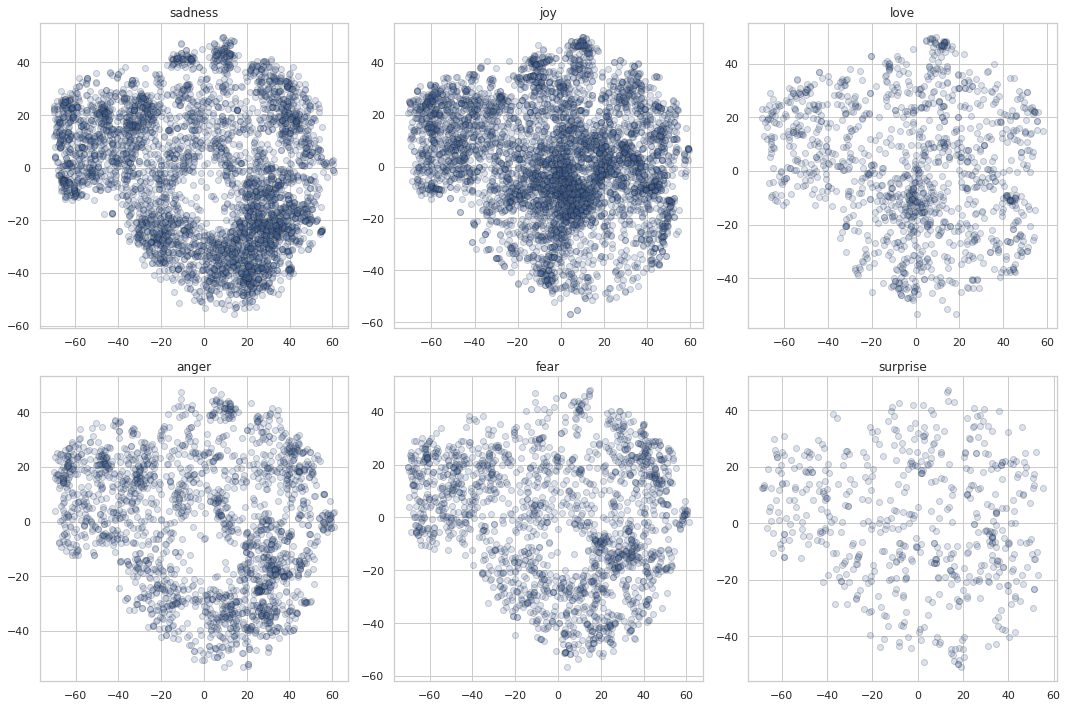

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes = axes.flatten()
labels = emotions["train"].features["label"].names

for i, label in enumerate(labels):
    
    dict_embedding_sub = dict(tuple(df_embedding.groupby('label')))
    df_embedding_sub = dict_embedding_sub[i]                        
                            
    axes[i].scatter(df_embedding_sub["X"], 
                    df_embedding_sub["Y"],
                    lw=1,ec='k',alpha=0.2)
    
    axes[i].set_title(f'{label}')

plt.tight_layout()
plt.show()

From this plot we can see some clear patterns: 
- For **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">positive emotions</mark>** (**<span style='color:#FFC300'>joy</span>** and **<span style='color:#FFC300'>love</span>**) are well separated from the **<span style='color:#FFC300'>negative emotions</span>** and also share a similar space
- **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Negative emotions</mark>** (**<span style='color:#FFC300'>sadness</span>**, **<span style='color:#FFC300'>anger</span>**, and **<span style='color:#FFC300'>fear</span>**) all occupy very similar regions with slightly varying distributions in **<span style='color:#FFC300'>lower dimension space</span>**
- Finally, **<span style='color:#FFC300'>surprise</span>** is somewhat scattered all over the **<span style='color:#FFC300'>lower dimension space</span>**

### **<span style='color:#F1A424'>Training a Baseline Model</span>**

- Let's use these **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">hidden states</mark>** to train a **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">logistic regression</mark>** model
- We're dealing with an unbalanced multiclass dataset, so our model may seem just better than random, but its actually better, let's compare to a `DummyClassifier`
- `DummyClassifier` can be used to build a classifier with simple heuristics (choosing the majority class/always drawing a random class), 
- Let's choose most frequent (`strategy="most_frequent"`) so we have a reference model for comparison

In [37]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
print(f'accuracy: {dummy_clf.score(X_valid, y_valid)}')

accuracy: 0.352


In [38]:
from sklearn.linear_model import LogisticRegression as LR

# We increase `max_iter` to guarantee convergence
lr_clf = LR(max_iter = 2000)
lr_clf.fit(X_train, y_train)
y_preds = lr_clf.predict(X_valid)
print(f'accuracy: {lr_clf.score(X_valid, y_valid)}')

accuracy: 0.6335


### <b><span style='color:#F1A424'>Confusion Matrix</span></b>

- Our **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">logistic regression</mark>** model with `DistilBERT` **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">embeddings</mark>** is signifcantly better than the baseline `DummyClassifier`
- Let check the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">confusion matrix</mark>** of the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">logistic regression</mark>** model

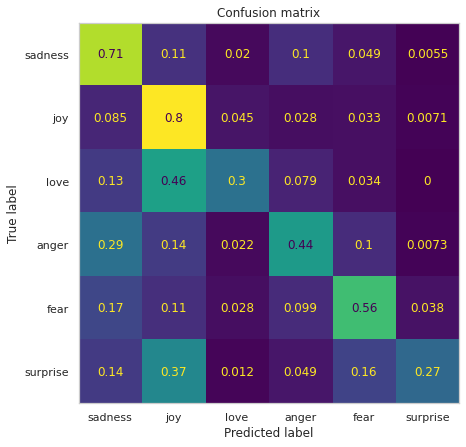

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_model, y_true, labels):
    cm = confusion_matrix(y_true,y_model,normalize='true')
    fig, ax = plt.subplots(figsize=(7,7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, colorbar=False)
    plt.title("Confusion matrix")
#     plt.axis('off')
    plt.grid(False)
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

From the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">confusion matrix</mark>** we can say that:

- **<span style='color:#FFC300'>anger</span>**, **<span style='color:#FFC300'>fear</span>** & **<span style='color:#FFC300'>surprise</span>** often confused with **<span style='color:#FFC300'>sadness</span>** (0.29, 0.17 & 0.14) (observation we made when visualising the embeddings)
- **<span style='color:#FFC300'>love</span>** & **<span style='color:#FFC300'>surprise</span>** are frequently mistaken for **<span style='color:#FFC300'>joy</span>** (0.37 & 0.46)

### <b><span style='color:#F1A424'> 5.2 | </span>Fine-tuning transformers </b> 

- With the fine-tune approach, we do not use the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">hidden states</mark>** as fixed features, instead, we train them from a given model state
- This requires the classification head to be differentiable (neural network for classification)

### <b><span style='color:#F1A424'>Loading a Pretrained Model</span></b>

- We'll load the same **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">DistilBERT</mark>** model using `model_ckpt` **"distilbert-base-uncased"** 
- This time however we will be loading `AutoModelForSequenceClassification` (we used `AutoModel` when we extracted embedding features)
- `AutoModelForSequenceClassification` model has a **<span style='color:#FFC300'>classification head</span>** on top of the pretrained model outputs
- We only need to specify the **<span style='color:#FFC300'>number of labels</span>** the model has to predict `num_labels`

In [40]:
from transformers import AutoModelForSequenceClassification

num_labels = 6

model_ckpt = "distilbert-base-uncased"
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, 
                          num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

### <b><span style='color:#F1A424'>Defining the Performance Metrics</span></b>
- We'll monitor the `F1 score`  & `accuracy`, the function is required to be passed in the `Trainer` class



In [41]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

### <b><span style='color:#F1A424'>Training parameters</span></b>
- Next we need to define the model **training parameters**, which can be done using `TrainingArguments`
- Let's train the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">DistilBERT</mark>** model for **3 iterations** with a **learning rate of 2e-5** and a **batch size of 64**

In [42]:
from transformers import Trainer, TrainingArguments

bs = 64 # batch size
logging_steps = len(emotions_encoded["train"]) // bs
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,             # number of training epochs
                                  learning_rate=2e-5,             # model learning rate
                                  per_device_train_batch_size=bs, # batch size
                                  per_device_eval_batch_size=bs,  # batch size
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False, 
                                  report_to="none",
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

### <b><span style='color:#F1A424'>Train Model</span></b>
- With the training arguments set, we need to define the `Trainer` and start training with the `train()` method

In [43]:
import os
from transformers import Trainer
os.environ['WANDB_DISABLED'] = 'true'

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.827500,0.285014,0.915500,0.914098
2,0.215500,0.184482,0.929000,0.929445
3,0.149100,0.167867,0.932000,0.932167


TrainOutput(global_step=750, training_loss=0.397378657023112, metrics={'train_runtime': 215.8696, 'train_samples_per_second': 222.356, 'train_steps_per_second': 3.474, 'total_flos': 1080514292544000.0, 'train_loss': 0.397378657023112, 'epoch': 3.0})

In [44]:
# Predict on Validation Dataset
pred_output = trainer.predict(emotions_encoded["validation"])
pred_output

PredictionOutput(predictions=array([[ 5.1261783 , -0.9283948 , -0.9856265 , -1.0444205 , -1.3228574 ,
        -1.5331591 ],
       [ 5.1002297 , -0.9166417 , -1.4029695 , -1.043348  , -0.9809644 ,
        -1.3637372 ],
       [-1.2395285 ,  2.8763258 ,  3.1577494 , -1.4294273 , -2.129735  ,
        -2.142409  ],
       ...,
       [-1.3957311 ,  5.208544  , -0.57876587, -1.1262094 , -1.9527779 ,
        -1.5724456 ],
       [-1.502901  ,  3.3421247 ,  2.998649  , -1.5469266 , -2.150778  ,
        -1.9889855 ],
       [-1.666739  ,  5.0579967 , -0.6802876 , -1.5876609 , -2.03388   ,
        -0.7135217 ]], dtype=float32), label_ids=array([0, 0, 2, ..., 1, 1, 1]), metrics={'test_loss': 0.1678665727376938, 'test_accuracy': 0.932, 'test_f1': 0.932166845300212, 'test_runtime': 2.6922, 'test_samples_per_second': 742.883, 'test_steps_per_second': 11.886})

In [45]:
print(f'Output Predition: {pred_output.predictions.shape}')
print(pred_output.predictions)

Output Predition: (2000, 6)
[[ 5.1261783  -0.9283948  -0.9856265  -1.0444205  -1.3228574  -1.5331591 ]
 [ 5.1002297  -0.9166417  -1.4029695  -1.043348   -0.9809644  -1.3637372 ]
 [-1.2395285   2.8763258   3.1577494  -1.4294273  -2.129735   -2.142409  ]
 ...
 [-1.3957311   5.208544   -0.57876587 -1.1262094  -1.9527779  -1.5724456 ]
 [-1.502901    3.3421247   2.998649   -1.5469266  -2.150778   -1.9889855 ]
 [-1.666739    5.0579967  -0.6802876  -1.5876609  -2.03388    -0.7135217 ]]


In [46]:
# Decode the predictions greedily using argmax (highest value of all classes)
y_preds = np.argmax(pred_output.predictions,axis=1)
print(f'Output Prediction:{y_preds.shape}')
print(f'Predictions: {y_preds}')

Output Prediction:(2000,)
Predictions: [0 0 2 ... 1 1 1]


In [47]:
# Show metrics of last iteration
pred_output.metrics

{'test_loss': 0.1678665727376938,
 'test_accuracy': 0.932,
 'test_f1': 0.932166845300212,
 'test_runtime': 2.6922,
 'test_samples_per_second': 742.883,
 'test_steps_per_second': 11.886}

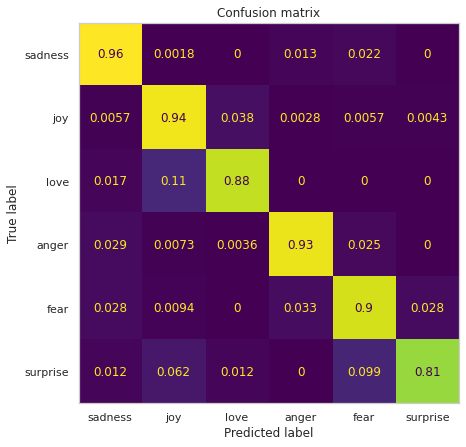

In [48]:
plot_confusion_matrix(y_preds,y_valid,labels)

From the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">confusion matrix</mark>** we can say that:
- The **fine-tune** approach (using **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">DistilBERT</mark>**)  performs much better than simple extracting **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">embedding</mark>** data and training it on a separate ML model
- **<span style='color:#FFC300'>love</span>** is still often confused with **<span style='color:#FFC300'>joy</span>** (0.08), but much less than the first approach
- **<span style='color:#FFC300'>surprise</span>** is often confused with **<span style='color:#FFC300'>joy</span>** as well (0.09) or fear (0.10), both also much less than the first approach

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#3b3745"><b><span style='color:#F1A424'>6 |</span></b> <b>MODEL ERROR ANALYSIS</b></div>

### <b><span style='color:#F1A424'>Loss Value Mapping</span></b>

We should investigate our models' prediction a little more 
- A simple, yet powerful technique is to sort the validateion by the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">model loss</mark>**
- We can write a function that returns the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">model loss</mark>**, together with the predicted label `forward_pass_with_label`

In [49]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
        
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label,
                                                                    batched=True, 
                                                                    batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

### <b><span style='color:#F1A424'>Convert to DataFrame</span></b>

- Create a DataFrame with the text, losses, predicted/true labels

In [50]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

- Now we can sort `emotions` encoded by the losses in either assending/descending order
- Let's look at the data samples with the **highest losses** (we can see that high loss values are associated with misspredictions)

In [51]:
show_panel(df_test.sort_values("loss", ascending=False))

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

In [52]:
show_panel(df_test.sort_values("loss", ascending=True))

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#3b3745"><b><span style='color:#F1A424'>7 |</span></b> <b>USING OUR MODEL</b></div>

- We have trained the model utilising `AutoModelForSequenceClassification` which added a classification head to the base **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">DistilBERT</mark>** model
- We can utilise the `pipeline` method when we need to make model predictions on new unseed data
- Let's say we have new unseen data: 
    - 'I watched a movie last night, it was quite brilliant'

In [53]:
# Save the model
trainer.save_model()

In [54]:
from transformers import pipeline

# load from previously saved model
classifier = pipeline("text-classification", model="distilbert-base-uncased-finetuned-emotion")

# New unseen by model data
new_data = 'I watched a movie last night, it was quite brilliant'

# New unseen by model data
new_data2 = 'He was badly concussed, the glass leaving two deep cuts across his forehead'

- Our model predicts `new_data` to be classified to **label 1** (**joy**)

In [55]:
preds = classifier(new_data, return_all_scores=True)
preds

[{'label': 'LABEL_0', 'score': 0.002958668628707528},
 {'label': 'LABEL_1', 'score': 0.9777346253395081},
 {'label': 'LABEL_2', 'score': 0.0023242230527102947},
 {'label': 'LABEL_3', 'score': 0.004569657612591982},
 {'label': 'LABEL_4', 'score': 0.002509291982278228},
 {'label': 'LABEL_5', 'score': 0.009903548285365105}]

In [56]:
preds1 = classifier(new_data2, return_all_scores=True)
preds1

[{'label': 'LABEL_0', 'score': 0.22846844792366028},
 {'label': 'LABEL_1', 'score': 0.029819458723068237},
 {'label': 'LABEL_2', 'score': 0.008075110614299774},
 {'label': 'LABEL_3', 'score': 0.25547024607658386},
 {'label': 'LABEL_4', 'score': 0.4607562720775604},
 {'label': 'LABEL_5', 'score': 0.0174105204641819}]

In [57]:
preds[0]

{'label': 'LABEL_0', 'score': 0.002958668628707528}

In [58]:
preds1[4]

{'label': 'LABEL_4', 'score': 0.4607562720775604}

In [59]:
import pandas as pd
import plotly.express as px

df_preds = pd.DataFrame(preds)
px.bar(x=labels,y=100*df_preds['score'],template='plotly_white')

In [60]:
df_preds = pd.DataFrame(preds1)
px.bar(x=labels,y=100*df_preds['score'],template='plotly_white')

In [61]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-emotion")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-emotion")

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# New unseen by model data
new_data = 'I watched a movie last night, it was quite brilliant'

# Tokenize the input text
tokenized_input = tokenizer(new_data, return_tensors="pt", truncation=True, padding=True)

# Move the inputs to the appropriate device (CPU or GPU)
tokenized_input = {key: val.to(device) for key, val in tokenized_input.items()}

# Make predictions
with torch.no_grad():
    outputs = model(**tokenized_input)

# Get the predicted labels
predicted_labels = torch.argmax(outputs.logits, dim=1)

# Convert predicted labels to emotion names
emotion_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
predicted_emotions = [emotion_names[label] for label in predicted_labels]

# Display the predictions
for text, emotion in zip(new_data, predicted_emotions):
    print(f"Text: {text}\nPredicted Emotion: {emotion}\n")

Text: I
Predicted Emotion: joy



In [62]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-emotion")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-emotion")

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# New unseen by model data
new_data = 'He is feeling sad because his pet died. People were sad that he was leaving. The experience left her sadder but wiser.'

# Tokenize the input text
tokenized_input = tokenizer(new_data, return_tensors="pt", truncation=True, padding=True)

# Move the inputs to the appropriate device (CPU or GPU)
tokenized_input = {key: val.to(device) for key, val in tokenized_input.items()}

# Make predictions
with torch.no_grad():
    outputs = model(**tokenized_input)

# Get the predicted labels
predicted_labels = torch.argmax(outputs.logits, dim=1)

# Convert predicted labels to emotion names
emotion_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
predicted_emotions = [emotion_names[label] for label in predicted_labels]

# Display the predictions
for text, emotion in zip(new_data, predicted_emotions):
    print(f"Text: {text}\nPredicted Emotion: {emotion}\n")

Text: H
Predicted Emotion: sadness



In [63]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-emotion")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-emotion")

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# New unseen by model data
new_data = 'That boy has quite a temper. He needs to learn to control his temper. She hit him in a fit of temper. He slammed the door and left in a temper.'

# Tokenize the input text
tokenized_input = tokenizer(new_data, return_tensors="pt", truncation=True, padding=True)

# Move the inputs to the appropriate device (CPU or GPU)
tokenized_input = {key: val.to(device) for key, val in tokenized_input.items()}

# Make predictions
with torch.no_grad():
    outputs = model(**tokenized_input)

# Get the predicted labels
predicted_labels = torch.argmax(outputs.logits, dim=1)

# Convert predicted labels to emotion names
emotion_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
predicted_emotions = [emotion_names[label] for label in predicted_labels]

# Display the predictions
for text, emotion in zip(new_data, predicted_emotions):
    print(f"Text: {text}\nPredicted Emotion: {emotion}\n")

Text: T
Predicted Emotion: anger



In [64]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-emotion")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-emotion")

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# New unseen by model data
new_data = 'When he walked into his birthday party, he was completely speechless. He stood there speechlessly.'

# Tokenize the input text
tokenized_input = tokenizer(new_data, return_tensors="pt", truncation=True, padding=True)

# Move the inputs to the appropriate device (CPU or GPU)
tokenized_input = {key: val.to(device) for key, val in tokenized_input.items()}

# Make predictions
with torch.no_grad():
    outputs = model(**tokenized_input)

# Get the predicted labels
predicted_labels = torch.argmax(outputs.logits, dim=1)

# Convert predicted labels to emotion names
emotion_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
predicted_emotions = [emotion_names[label] for label in predicted_labels]

# Display the predictions
for text, emotion in zip(new_data, predicted_emotions):
    print(f"Text: {text}\nPredicted Emotion: {emotion}\n")

Text: W
Predicted Emotion: surprise



In [65]:
# Set the maximum number of rows to None to display all rows
pd.set_option('display.max_rows', None)

df.head(150)

,text,label,label_name,Words Per Tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4
5,ive been feeling a little burdened lately wasn...,0,sadness,12
6,ive been taking or milligrams or times recomme...,5,surprise,23
7,i feel as confused about life as a teenager or...,4,fear,17
8,i have been with petronas for years i feel tha...,1,joy,19
9,i feel romantic too,2,love,4


## EMOTIONAL MODEL PREDICTION

In [66]:
import os

os.listdir('/kaggle/input')

['enron-clean-v2-csv',
 'enron-clean-v4',
 'enron-clean-reduced-temp-khcwsmerge-final-csv',
 'emotion-dataset',
 'enron-clean-reduced-temp-khcwsmerge-final2-csv']

### Enron Clean Version 2 - Machine Learning Training Dataset
### Text Data Preprocessing

In this preprocessing pipeline, we will perform several steps to clean and prepare text data for analysis or modeling. Each step is aimed at removing noise and irrelevant information from the text, making it suitable for further processing. Here are the details of each step:

- Decontracted: Expand contracted words like "can't" to "cannot", "won't" to "will not", etc.
- Remove Numbers: Eliminate numerical digits from the text.
- Remove HTML: Strip HTML tags from the text, if present.
- Remove URL: Remove any URLs or hyperlinks from the text.
- Remove Punctuations: Exclude punctuation marks such as commas, periods, exclamation marks, etc.
- Remove Patterns: Delete any specific patterns or regular expressions from the text.
- Remove Stopwords: Eliminate common stopwords (e.g., "the", "is", "and") from the text.
- After applying these preprocessing steps, the text data will be cleaned and ready for further analysis, such as text mining, sentiment analysis, or topic modeling.

#### Tokenization
Tokenization is the process of splitting a text into smaller units, such as words or punctuation marks. In this step, we use the word_tokenize() function from NLTK to tokenize the text into words. Lowercasing: We convert all the tokens to lowercase to ensure uniformity and prevent the model from treating words with different cases as different entities.

#### Removing Stopwords
Stopwords are common words that often do not carry significant meaning, such as 'the', 'is', 'and', etc. We remove these stopwords using NLTK's English stopwords corpus.

#### Lemmatization
Lemmatization is the process of reducing words to their base or root form. For example, 'running' and 'ran' both get reduced to 'run'. NLTK's WordNetLemmatizer is used for lemmatization.

In [67]:
import pandas as pd

# Define the path to the CSV file
file_path = '/kaggle/input/enron-clean-v4/enron_clean_V4.csv'

# Read the CSV file into a DataFrame
df2 = pd.read_csv(file_path)

# Set the maximum number of rows to None to display all rows
pd.set_option('display.max_row', None)

# Set the maximum number of columns to None to display all columns
#pd.set_option('display.max_colwidth', None)
#pd.reset_option('display.max_colwidth')

# Display df2
df2.head()

,Year,Month,Day,Hour,Day_of_week,sentiment_score_compound,sentiment_score_positive,sentiment_score_neutral,sentiment_score_negative,Sender-Type,...,JJ,NNS,IN,DT,CC,JJS,WP,NN,JJR,cleaned_body
0,2000,11,16,17,3,0.9616,0.226,0.708,0.066,0,...,8,1,12,8,2,1,1,13,0,status john really sure happen impression visi...
1,2000,12,8,13,4,0.5940,0.074,0.926,0.000,0,...,8,3,3,4,2,0,0,15,1,summer inverse suck hope make money natga last...
2,2001,5,15,16,1,-0.3923,0.036,0.918,0.045,0,...,6,10,9,9,1,0,1,26,0,wti bullet swap contract hi follow e mail rece...
3,2000,12,12,7,1,-0.4767,0.000,0.829,0.171,0,...,2,0,1,0,0,0,0,10,0,fwd article suspend rabbi quit seminary presid...
4,2001,5,15,6,1,-0.0772,0.058,0.893,0.050,0,...,14,17,23,16,11,0,0,19,0,daily chart matrix hot link information contai...


In [68]:
# Set the maximum number of rows to None to display all rows
pd.reset_option('display.max_colwidth')

df2.head(20)

,Year,Month,Day,Hour,Day_of_week,sentiment_score_compound,sentiment_score_positive,sentiment_score_neutral,sentiment_score_negative,Sender-Type,...,JJ,NNS,IN,DT,CC,JJS,WP,NN,JJR,cleaned_body
0,2000,11,16,17,3,0.9616,0.226,0.708,0.066,0,...,8,1,12,8,2,1,1,13,0,status john really sure happen impression visi...
1,2000,12,8,13,4,0.5940,0.074,0.926,0.000,0,...,8,3,3,4,2,0,0,15,1,summer inverse suck hope make money natga last...
2,2001,5,15,16,1,-0.3923,0.036,0.918,0.045,0,...,6,10,9,9,1,0,1,26,0,wti bullet swap contract hi follow e mail rece...
3,2000,12,12,7,1,-0.4767,0.000,0.829,0.171,0,...,2,0,1,0,0,0,0,10,0,fwd article suspend rabbi quit seminary presid...
4,2001,5,15,6,1,-0.0772,0.058,0.893,0.050,0,...,14,17,23,16,11,0,0,19,0,daily chart matrix hot link information contai...
5,2000,11,10,13,4,0.9915,0.244,0.742,0.014,0,...,13,7,16,14,8,0,0,37,0,resume john thank email offer route resume exp...
6,2000,11,29,16,2,0.7226,0.108,0.838,0.055,0,...,13,9,11,17,8,0,0,21,0,wrong address john think wrong email address b...
7,2001,5,14,13,0,0.9800,0.090,0.886,0.024,0,...,34,30,39,31,20,0,0,56,1,additional offering round portfolio john leave...
8,2000,12,7,9,3,-0.3513,0.059,0.856,0.086,0,...,13,9,17,10,5,0,2,34,0,crazy mite scale little sort length sprd lengt...
9,2000,11,28,16,1,0.8429,0.183,0.817,0.000,0,...,3,0,4,3,1,0,0,9,0,little bird tell read time get free zdnet oneb...


In [69]:
# import nltk
# import string
# import re
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer

# # Download necessary NLTK resources
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# # Initialize NLTK components
# stop_words = set(stopwords.words('english'))  # Set of English stopwords
# lemmatizer = WordNetLemmatizer()  # Word lemmatizer

# # Define punctuation marks using string module
# punctuation_marks = string.punctuation

# # Define a function to preprocess text
# def preprocess_text(text):
#     if isinstance(text, str):  # Check if input is a string
#         # Remove numbers
#         text = re.sub(r'\d+', '', text)
#         # Remove HTML tags
#         text = re.sub(r'<.*?>', '', text)
#         # Remove URLs
#         text = re.sub(r'http\S+|www\S+|https\S+', '', text)
#         # Tokenize text into words and convert to lowercase
#         tokens = word_tokenize(text.lower())
#         # Remove punctuation marks and non-alphanumeric tokens
#         tokens = [token for token in tokens if token.isalnum() and token not in punctuation_marks]
#         # Lemmatize words and remove stopwords
#         tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
#         # Join the preprocessed tokens back into a string
#         return " ".join(tokens)
#     else:
#         return ""  # Return empty string for non-string inputs

# # Apply the preprocessing function to the 'Body' column of the DataFrame
# df2['cleaned_body'] = df2['Body_lemma'].apply(preprocess_text)

In [70]:
df2.head(20)

,Year,Month,Day,Hour,Day_of_week,sentiment_score_compound,sentiment_score_positive,sentiment_score_neutral,sentiment_score_negative,Sender-Type,...,JJ,NNS,IN,DT,CC,JJS,WP,NN,JJR,cleaned_body
0,2000,11,16,17,3,0.9616,0.226,0.708,0.066,0,...,8,1,12,8,2,1,1,13,0,status john really sure happen impression visi...
1,2000,12,8,13,4,0.5940,0.074,0.926,0.000,0,...,8,3,3,4,2,0,0,15,1,summer inverse suck hope make money natga last...
2,2001,5,15,16,1,-0.3923,0.036,0.918,0.045,0,...,6,10,9,9,1,0,1,26,0,wti bullet swap contract hi follow e mail rece...
3,2000,12,12,7,1,-0.4767,0.000,0.829,0.171,0,...,2,0,1,0,0,0,0,10,0,fwd article suspend rabbi quit seminary presid...
4,2001,5,15,6,1,-0.0772,0.058,0.893,0.050,0,...,14,17,23,16,11,0,0,19,0,daily chart matrix hot link information contai...
5,2000,11,10,13,4,0.9915,0.244,0.742,0.014,0,...,13,7,16,14,8,0,0,37,0,resume john thank email offer route resume exp...
6,2000,11,29,16,2,0.7226,0.108,0.838,0.055,0,...,13,9,11,17,8,0,0,21,0,wrong address john think wrong email address b...
7,2001,5,14,13,0,0.9800,0.090,0.886,0.024,0,...,34,30,39,31,20,0,0,56,1,additional offering round portfolio john leave...
8,2000,12,7,9,3,-0.3513,0.059,0.856,0.086,0,...,13,9,17,10,5,0,2,34,0,crazy mite scale little sort length sprd lengt...
9,2000,11,28,16,1,0.8429,0.183,0.817,0.000,0,...,3,0,4,3,1,0,0,9,0,little bird tell read time get free zdnet oneb...


In [71]:
df2.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Day_of_week',
       'sentiment_score_compound', 'sentiment_score_positive',
       'sentiment_score_neutral', 'sentiment_score_negative', 'Sender-Type',
       'Unique-Mails-From-Sender', 'Contains-Reply-Forwards', 'Subject_lemma',
       'Body_lemma', 'Subject_num_sentences', 'Subject_median_chars_per_word',
       'Subject_median_words_per_sentence', 'Subject_uppercase_ratio',
       'Subject_punctuation_ratio', 'Subject_typo_ratio',
       'Subject_special_chars_ratio', 'Body_num_sentences',
       'Body_median_chars_per_word', 'Body_median_words_per_sentence',
       'Body_uppercase_ratio', 'Body_punctuation_ratio', 'Body_typo_ratio',
       'Body_special_chars_ratio', 'Bcc_count', 'Label',
       'Body_lexical_complexity', 'Body_lemma_dominant_topic',
       'Subject_lemma_dominant_topic', 'VBZ', 'VBD', 'CD', 'PRP', 'VB', 'VBN',
       'RB', 'TO', 'RP', 'VBG', 'NNP', 'VBP', 'JJ', 'NNS', 'IN', 'DT', 'CC',
       'JJS', 'WP', 'NN', 'JJR', 'cl

## Test on Enron Fraud Dataset

In [72]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-emotion")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-emotion")

# Allocate model to appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function predict emotions for given text
def predict_emotion(text):
    # Tokenize the input text
    tokenized_input = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    # Move the inputs to the appropriate device (CPU or GPU)
    tokenized_input = {key: val.to(device) for key, val in tokenized_input.items()}
    # Make predictions
    with torch.no_grad():
        outputs = model(**tokenized_input)
    # Get the predicted labels
    predicted_labels = torch.argmax(outputs.logits, dim=1)
    # Convert predicted labels to emotion names
    emotion_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
    predicted_emotions = [emotion_names[label] for label in predicted_labels]
    return predicted_emotions[0]

# Testing first 100 rows df
df2_subset = df2.head(100)  # Selecting the first 100 rows for testing
df2_subset['predicted_emotion'] = df2_subset['cleaned_body'].apply(predict_emotion)

# Display df with predicted emotions
print(df2_subset[['cleaned_body', 'predicted_emotion']])


                                         cleaned_body predicted_emotion
0   status john really sure happen impression visi...               joy
1   summer inverse suck hope make money natga last...               joy
2   wti bullet swap contract hi follow e mail rece...               joy
3   fwd article suspend rabbi quit seminary presid...               joy
4   daily chart matrix hot link information contai...               joy
5   resume john thank email offer route resume exp...               joy
6   wrong address john think wrong email address b...             anger
7   additional offering round portfolio john leave...               joy
8   crazy mite scale little sort length sprd lengt...              fear
9   little bird tell read time get free zdnet oneb...               joy
10  big news sure hear fun news yet rob move bosto...               joy
11  think rite curve flatten end overvalue part th...               joy
12  bnp paribas commodity future ng marketwatch se...           

## Backup

In [73]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-emotion")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-emotion")

# Allocate model to appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function predict emotions for given text
def predict_emotion(text):
    # Tokenize the input text
    tokenized_input = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    # Move the inputs to the appropriate device (CPU or GPU)
    tokenized_input = {key: val.to(device) for key, val in tokenized_input.items()}
    # Make predictions
    with torch.no_grad():
        outputs = model(**tokenized_input)
    # Get the predicted labels
    predicted_labels = torch.argmax(outputs.logits, dim=1)
    # Convert predicted labels to emotion names
    emotion_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
    predicted_emotions = [emotion_names[label] for label in predicted_labels]
    return predicted_emotions[0]

# Testing first 100 rows df
df2_subset = df2.head(100)  # Selecting the first 100 rows for testing
df2_subset['predicted_emotion'] = df2_subset['cleaned_body'].apply(predict_emotion)

# Display df with predicted emotions
print(df2_subset[['cleaned_body', 'predicted_emotion']])


                                         cleaned_body predicted_emotion
0   status john really sure happen impression visi...               joy
1   summer inverse suck hope make money natga last...               joy
2   wti bullet swap contract hi follow e mail rece...               joy
3   fwd article suspend rabbi quit seminary presid...               joy
4   daily chart matrix hot link information contai...               joy
5   resume john thank email offer route resume exp...               joy
6   wrong address john think wrong email address b...             anger
7   additional offering round portfolio john leave...               joy
8   crazy mite scale little sort length sprd lengt...              fear
9   little bird tell read time get free zdnet oneb...               joy
10  big news sure hear fun news yet rob move bosto...               joy
11  think rite curve flatten end overvalue part th...               joy
12  bnp paribas commodity future ng marketwatch se...           

## Apply Emotion Prediction Model to Enron Clean V4 Dataset

In [74]:
df2.head(20)

,Year,Month,Day,Hour,Day_of_week,sentiment_score_compound,sentiment_score_positive,sentiment_score_neutral,sentiment_score_negative,Sender-Type,...,JJ,NNS,IN,DT,CC,JJS,WP,NN,JJR,cleaned_body
0,2000,11,16,17,3,0.9616,0.226,0.708,0.066,0,...,8,1,12,8,2,1,1,13,0,status john really sure happen impression visi...
1,2000,12,8,13,4,0.5940,0.074,0.926,0.000,0,...,8,3,3,4,2,0,0,15,1,summer inverse suck hope make money natga last...
2,2001,5,15,16,1,-0.3923,0.036,0.918,0.045,0,...,6,10,9,9,1,0,1,26,0,wti bullet swap contract hi follow e mail rece...
3,2000,12,12,7,1,-0.4767,0.000,0.829,0.171,0,...,2,0,1,0,0,0,0,10,0,fwd article suspend rabbi quit seminary presid...
4,2001,5,15,6,1,-0.0772,0.058,0.893,0.050,0,...,14,17,23,16,11,0,0,19,0,daily chart matrix hot link information contai...
5,2000,11,10,13,4,0.9915,0.244,0.742,0.014,0,...,13,7,16,14,8,0,0,37,0,resume john thank email offer route resume exp...
6,2000,11,29,16,2,0.7226,0.108,0.838,0.055,0,...,13,9,11,17,8,0,0,21,0,wrong address john think wrong email address b...
7,2001,5,14,13,0,0.9800,0.090,0.886,0.024,0,...,34,30,39,31,20,0,0,56,1,additional offering round portfolio john leave...
8,2000,12,7,9,3,-0.3513,0.059,0.856,0.086,0,...,13,9,17,10,5,0,2,34,0,crazy mite scale little sort length sprd lengt...
9,2000,11,28,16,1,0.8429,0.183,0.817,0.000,0,...,3,0,4,3,1,0,0,9,0,little bird tell read time get free zdnet oneb...


In [75]:
df2.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Day_of_week',
       'sentiment_score_compound', 'sentiment_score_positive',
       'sentiment_score_neutral', 'sentiment_score_negative', 'Sender-Type',
       'Unique-Mails-From-Sender', 'Contains-Reply-Forwards', 'Subject_lemma',
       'Body_lemma', 'Subject_num_sentences', 'Subject_median_chars_per_word',
       'Subject_median_words_per_sentence', 'Subject_uppercase_ratio',
       'Subject_punctuation_ratio', 'Subject_typo_ratio',
       'Subject_special_chars_ratio', 'Body_num_sentences',
       'Body_median_chars_per_word', 'Body_median_words_per_sentence',
       'Body_uppercase_ratio', 'Body_punctuation_ratio', 'Body_typo_ratio',
       'Body_special_chars_ratio', 'Bcc_count', 'Label',
       'Body_lexical_complexity', 'Body_lemma_dominant_topic',
       'Subject_lemma_dominant_topic', 'VBZ', 'VBD', 'CD', 'PRP', 'VB', 'VBN',
       'RB', 'TO', 'RP', 'VBG', 'NNP', 'VBP', 'JJ', 'NNS', 'IN', 'DT', 'CC',
       'JJS', 'WP', 'NN', 'JJR', 'cl

In [76]:
df2_types = df2.dtypes
print(df2_types)

Year                                   int64
Month                                  int64
Day                                    int64
Hour                                   int64
Day_of_week                            int64
sentiment_score_compound             float64
sentiment_score_positive             float64
sentiment_score_neutral              float64
sentiment_score_negative             float64
Sender-Type                            int64
Unique-Mails-From-Sender             float64
Contains-Reply-Forwards                int64
Subject_lemma                         object
Body_lemma                            object
Subject_num_sentences                float64
Subject_median_chars_per_word        float64
Subject_median_words_per_sentence    float64
Subject_uppercase_ratio              float64
Subject_punctuation_ratio            float64
Subject_typo_ratio                   float64
Subject_special_chars_ratio          float64
Body_num_sentences                   float64
Body_media

In [ ]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-emotion")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-emotion")

# Allocate model to appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to predict emotions for given text
def predict_emotion(text):
    max_seq_length = tokenizer.model_max_length
    # Truncate or split the input text if it exceeds the maximum sequence length
    if len(text) > max_seq_length:
        # Truncate the text
        text = text[:max_seq_length]
    # Tokenize the input text
    tokenized_input = tokenizer(text, return_tensors="pt")
    input_ids = tokenized_input["input_ids"].to(device)
    # Make predictions
    with torch.no_grad():
        outputs = model(input_ids)
    # Get the predicted labels
    predicted_labels = torch.argmax(outputs.logits, dim=1)
    # Convert predicted labels to emotion names
    emotion_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
    predicted_emotions = [emotion_names[label] for label in predicted_labels]
    return predicted_emotions[0]

# Convert float values to strings in the 'cleaned_body' column
df2['cleaned_body'] = df2['cleaned_body'].astype(str)

# Apply predict_emotion function to the 'cleaned_body' column
df2['predicted_emotion'] = df2['cleaned_body'].apply(predict_emotion)

# Display df with predicted emotions
print(df2[['cleaned_body', 'predicted_emotion']])

# Optionally, save the DataFrame back to CSV
# df2.to_csv("predicted_df2.csv", index=False)


In [ ]:
# Save DataFrame to CSV file on Kaggle
df2.to_csv('/kaggle/working/df2_predicted_emotions.csv', index=False)

# Download the CSV file to local machine
from IPython.display import FileLink
FileLink(r'/kaggle/working/df2_predicted_emotions.csv')

In [ ]:
df2.head(100)

In [ ]:
# # Step 1: Create a CSV file from df2
# df2.to_csv('/kaggle/working/enron_clean_V4.csv', index=False)

# # Step 2: Upload the CSV file to your Kaggle dataset
# # Make sure you have set up a Kaggle API token and installed the Kaggle package.
# # Then you can use the following command to upload the CSV file to your dataset.
# !kaggle datasets version -p /kaggle/working -m "Added Enron clean V4 dataset" -r zip

### Enron Clean Reduced Temp KhcWSMerge Final - Feature Dataset
### Text Data Preprocessing

In this preprocessing pipeline, we will perform several steps to clean and prepare text data for analysis or modeling. Each step is aimed at removing noise and irrelevant information from the text, making it suitable for further processing. Here are the details of each step:

- Decontracted: Expand contracted words like "can't" to "cannot", "won't" to "will not", etc.
- Remove Numbers: Eliminate numerical digits from the text.
- Remove HTML: Strip HTML tags from the text, if present.
- Remove URL: Remove any URLs or hyperlinks from the text.
- Remove Punctuations: Exclude punctuation marks such as commas, periods, exclamation marks, etc.
- Remove Patterns: Delete any specific patterns or regular expressions from the text.
- Remove Stopwords: Eliminate common stopwords (e.g., "the", "is", "and") from the text.
- After applying these preprocessing steps, the text data will be cleaned and ready for further analysis, such as text mining, sentiment analysis, or topic modeling.


#### Tokenization
Tokenization is the process of splitting a text into smaller units, such as words or punctuation marks. In this step, we use the word_tokenize() function from NLTK to tokenize the text into words. Lowercasing: We convert all the tokens to lowercase to ensure uniformity and prevent the model from treating words with different cases as different entities.

#### Removing Stopwords
Stopwords are common words that often do not carry significant meaning, such as 'the', 'is', 'and', etc. We remove these stopwords using NLTK's English stopwords corpus.

#### Lemmatization
Lemmatization is the process of reducing words to their base or root form. For example, 'running' and 'ran' both get reduced to 'run'. NLTK's WordNetLemmatizer is used for lemmatization.

In [ ]:
import pandas as pd

# Define the path to the CSV file
file_path = '/kaggle/input/enron-clean-reduced-temp-khcwsmerge-final2-csv/enron_clean_reduced_temp_KHCWSMerge_final2.csv'

# Read the CSV file into a DataFrame
df3 = pd.read_csv(file_path)

# Set the maximum number of rows to None to display all rows
pd.set_option('display.max_row', None)

# Set the maximum number of columns to None to display all columns
#pd.set_option('display.max_colwidth', None)
#pd.reset_option('display.max_colwidth')

# Display df2
df3.head()

In [ ]:
# import nltk
# import string
# import re
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer

# # Download necessary NLTK resources
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# # Initialize NLTK components
# stop_words = set(stopwords.words('english'))  # Set of English stopwords
# lemmatizer = WordNetLemmatizer()  # Word lemmatizer

# # Define punctuation marks using string module
# punctuation_marks = string.punctuation

# # Define a function to preprocess text
# def preprocess_text(text):
#     if isinstance(text, str):  # Check if input is a string
#         # Remove numbers
#         text = re.sub(r'\d+', '', text)
#         # Remove HTML tags
#         text = re.sub(r'<.*?>', '', text)
#         # Remove URLs
#         text = re.sub(r'http\S+|www\S+|https\S+', '', text)
#         # Tokenize text into words and convert to lowercase
#         tokens = word_tokenize(text.lower())
#         # Remove punctuation marks and non-alphanumeric tokens
#         tokens = [token for token in tokens if token.isalnum() and token not in punctuation_marks]
#         # Lemmatize words and remove stopwords
#         tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
#         # Join the preprocessed tokens back into a string
#         return " ".join(tokens)
#     else:
#         return ""  # Return empty string for non-string inputs

# # Apply the preprocessing function to the 'Body' column of the DataFrame
# df3['cleaned_body'] = df3['Body'].apply(preprocess_text)

In [ ]:
df3.columns

In [ ]:
# # Step 1: Create a CSV file from df2
# df2.to_csv('/kaggle/working/enron_clean_reduced_temp_KHCWSMerge_final2.csv', index=False)

# # Step 2: Upload the CSV file to your Kaggle dataset
# # Make sure you have set up a Kaggle API token and installed the Kaggle package.
# # Then you can use the following command to upload the CSV file to your dataset.
# !kaggle datasets version -p /kaggle/working -m "Added Enron clean KHCWSMerge Final 2 dataset" -r zip

In [ ]:
# from transformers import pipeline

# # Load the emotion classification model
# classifier = pipeline("text-classification", model="distilbert-base-uncased-finetuned-emotion")

# # Define a function to predict emotions with truncation
# def predict_emotion(text):
#     # Define the maximum sequence length supported by the model
#     max_seq_length = classifier.model.config.max_position_embeddings
    
#     # Truncate the input text if it exceeds the maximum sequence length
#     if len(text) > max_seq_length:
#         text = text[:max_seq_length]
    
#     # Use the classifier pipeline to predict emotions
#     result = classifier(text)
    
#     # Extract the predicted label and its score
#     predicted_label = result[0]['label']
#     score = result[0]['score']
    
#     return predicted_label, score

# # Apply the predict_emotion function to the 'Body' column of the df
# df['Predicted_Emotion'] = df['cleaned_body'].apply(predict_emotion)

# # Display the df predicted emotions
# print(df[['cleaned_body', 'Predicted_Emotion']])


In [ ]:
# import pandas as pd

# # Display all rows
# pd.set_option('display.max_rows', None)
# # pd.reset_option('display.max_rows')

# # Display df
# df.head(1000)

- Our dataset has 6 classes `joy`, `sadness`, `anger`, `fear`, `love` and `surprise`; multiclass problem

In [ ]:
# import pandas as pd
# import plotly.express as px

# # Assuming 'df' is your existing DataFrame containing the column 'Predicted_Emotion'

# # Extract label and score from the 'Predicted_Emotion' column
# df[['Label', 'Score']] = df['Predicted_Emotion'].str.extract(r'\(([^,]+), ([^)]+)\)')

# # Convert score to numeric type
# df['Score'] = pd.to_numeric(df['Score'])

# # Plot the bar graph using Plotly
# fig = px.bar(x=df['Label'], y=100*df['Score'], template='plotly_white', labels={'x': 'Labels', 'y': 'Score (%)'})
# fig.show()

In [ ]:
# from transformers import pipeline

# # Create a TruncationPipeline with your desired truncation strategy
# truncation_pipeline = pipeline("text-generation", truncation=True, max_length=512, padding="max_length")

# # Define a function to truncate the input text
# def truncate_text(text, strategy="longest_first"):
#     # Use the truncation pipeline to truncate the text
#     truncated_text = truncation_pipeline(text, truncation_strategy=strategy)
#     return truncated_text[0]["generated_text"]

# # Apply the truncate_text function to the 'Body' column of the DataFrame
# df['Truncated_Body'] = df['Body'].apply(truncate_text)

# # Display the DataFrame with truncated text
# print(df[['Body', 'Truncated_Body']])


In [ ]:
df.head(50)

In [ ]:
# # Define a function to predict emotions for each segment of text and store the results in new columns
# def predict_emotion(text):
#     # Split the input text into segments
#     max_seq_length = classifier.model.config.max_position_embeddings
#     segments = [text[i:i+max_seq_length] for i in range(0, len(text), max_seq_length)]
    
#     # Predict emotions for each segment
#     results = []
#     for segment in segments:
#         result = classifier(segment)
#         results.extend(result)
    
#     # Extract the predicted labels and scores for each segment
#     predicted_labels = [res['label'] for res in results]
#     scores = [res['score'] for res in results]
    
#     return predicted_labels, scores

# # Apply the predict_emotion function to the 'Body' column of the DataFrame
# df['Predicted_Emotions'], df['Emotion_Scores'] = zip(*df['Body'].apply(predict_emotion))

# # Display the DataFrame with predicted emotions and scores
# print(df[['Body', 'Predicted_Emotions', 'Emotion_Scores']])

This error typically occurs when there is a mismatch in the input sizes expected by the model and the actual input provided. Specifically, the error message indicates that there is a size mismatch between two tensors at dimension 1.

In the context of the DistilBERT model, the input sequence length is fixed to a certain size (usually 512 tokens). However, in your case, the length of the input text (538 tokens) exceeds this fixed size, leading to the dimension mismatch error.

To resolve this issue, you can preprocess your input text to ensure that it does not exceed the maximum sequence length expected by the model. You can truncate the text to fit within the maximum sequence length or use techniques like chunking to process longer texts.

Here's a brief overview of how you can handle this:

Truncation: Simply truncate the input text to fit within the maximum sequence length. You can choose to truncate either from the beginning, end, or both sides of the text.

Chunking: If truncation results in significant loss of information, you can divide the input text into smaller chunks, process each chunk separately, and then aggregate the predictions.

You can implement these preprocessing techniques before passing the text to the model for prediction to ensure that it conforms to the expected input size.

In [ ]:
from transformers import pipeline

# # load from previously saved model
# classifier = pipeline("text-classification", model="distilbert-base-uncased-finetuned-emotion")

# # Define a function to apply the emotion classification model to text
# def predict_emotion(text):
#     # Use the classifier pipeline to predict emotions
#     result = classifier(text)
#     # Extract the predicted label
#     predicted_label = result[0]['label']
#     return predicted_label

# # Apply the predict_emotion function to the 'Body' column of the DataFrame
# df['Predicted_Emotion'] = df['Body'].apply(predict_emotion)

# # Display the DataFrame with predicted emotions
# print(df[['Body', 'Predicted_Emotion']])
